# Permutação de Colunas

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

#### Tem de ler muito a descrição do sklearn #####
from sklearn.linear_model import *
from sklearn.datasets import fetch_openml, fetch_california_housing
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasRegressor
from keras import optimizers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler



## Funções para permutação

In [2]:
### UTILITY FUNCTION FOR FEATURES PERMUTATION IMPORTANCE ###

## Precisa entrar com o modelo ajustado
## Matriz de X, variáveis explicativas
### Matriz de y variável resposta(preços das casas)

### Função de perdatem de entrar também
### é a função de banchmarket
### Número de repetições
### Você pode usar nome da coluna e um seed para marcar o aleatório


def permut_features_importance(
    model, X, y, 
    loss_fun, n_repeats=10,
    seed=None, columns_name=None
):
    
    X = np.asarray(X)
    assert X.ndim == 2
    
    y = np.asarray(y)
    assert y.ndim < 2
    
    if seed is not None:
        np.random.seed(seed)
    
    if columns_name is not None:
        assert len(columns_name) == X.shape[-1]
    else:
        columns_name = np.arange(X.shape[-1])
        
    error = loss_fun(model, X, y)
    features_imp = {}
    std_features_imp = {}     
        
    for col in tqdm(range(X.shape[-1])):
        
        _importance = []
        for _ in range(n_repeats):
            
            _X = np.copy(X)
            _X[:,col] = np.random.permutation(_X[:,col])
            _importance.append(loss_fun(model, _X, y) - error)
                
        features_imp[columns_name[col]] = np.mean(_importance)
        std_features_imp[columns_name[col]] = np.std(_importance)
                
    return features_imp, std_features_imp
### Vai retornar as importâncias relativas das variáveis
### e desvio padrão da importância média em n-repetições da permutação

## Função de perda utilizando o MSE

Aqui a gente vai brincar de calcular o MSE e também a diferença entre 
o modelo base e o novo modelo 


In [3]:

def mse(model, X, true, normalize=True): 
    
    if normalize:
        return np.mean(np.square(true - model.predict(X)))
    else:
        return np.square(true - model.predict(X)) 


def crossentropy(model, X, true, normalize=True):
    
    def _entropy(true, pred): return -(true * np.log(pred))
    
    true = np.asarray(true)
    classes = np.unique(true)
    pred_proba = model.predict_proba(X)
    pred_proba = pred_proba.clip(1e-5, 1 - 1e-5)
    
    c_entropy = np.zeros_like(true, dtype='float64')
    for c,cls in enumerate(classes):
        true_cls = (true == cls).astype(int)
        c_entropy += _entropy(true_cls, pred_proba[:,c])
    
    if normalize:
        return c_entropy.mean()
    else:
        return c_entropy

## Lendo o Banco de dados e ajustando o modelo base

In [4]:
np.random.seed(123)

import warnings

import pandas as pd
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


X, y = fetch_california_housing(return_X_y=True, as_frame=True)
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1)
X_train[['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']] =  scaler.fit_transform(X_train[['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']])
X_test[['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']] =  scaler.fit_transform(X_test[['MedInc','HouseAge','AveRooms','AveBedrms','Population','AveOccup','Latitude','Longitude']])
import warnings


### Problema de regressão de para prever o valor de casas a partir de variáveis numéricas

In [5]:
def base_model():
    model = Sequential()
    model.add(Dense(5, input_dim=8, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2 ,activation='relu'))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer= optimizers.Adam(lr=0.001))
    return model

In [6]:
np.random.seed(123)
model = KerasRegressor(build_fn=base_model, batch_size=50, epochs=150, verbose = 0)

model.fit(X_train,y_train)

mse(model, X_test, y_test)

0.3524903746601174

## Ajustando o modelo

In [7]:
feat_imp_diz = permut_features_importance(model, X_test, y_test, loss_fun=mse, n_repeats=20, 
                                          columns_name=X.columns)


feat_imp_mean, feat_imp_std = feat_imp_diz

feat_imp_mean = pd.Series(feat_imp_mean)
feat_imp_std = pd.Series(feat_imp_std)

order = feat_imp_mean.sort_values(ascending=False).index
feat_imp_mean = feat_imp_mean[order]
feat_imp_std = feat_imp_std[order]

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/it]


### Gráfico de Importância das Variáveis

Text(0, 0.5, 'importance')

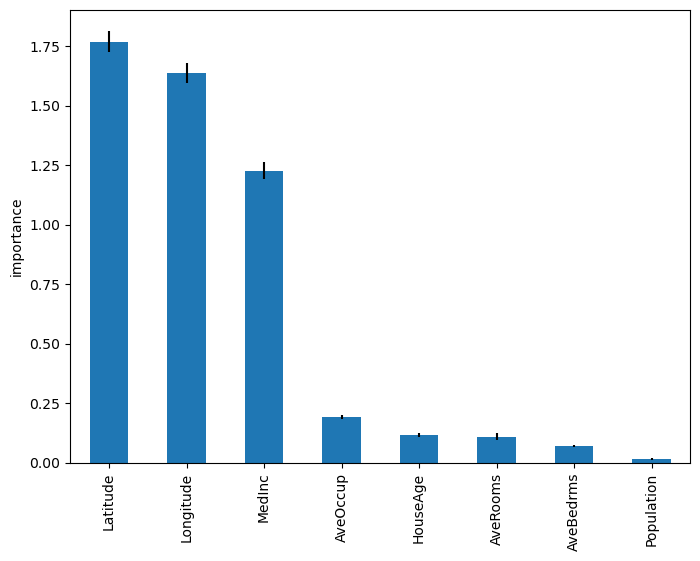

In [8]:
plt.figure(figsize=(8,6), dpi=100)
plot = feat_imp_mean.plot.bar(yerr=feat_imp_std)
plt.ylabel('importance')

In [9]:
def model_retira():
    model = Sequential()
    model.add(Dense(5, input_dim=7, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2 ,activation='relu'))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer= optimizers.Adam(lr=0.001))
    return model

retira = KerasRegressor(build_fn=model_retira, batch_size=50, epochs=150, verbose = 0)


In [10]:

def Retira_coluna (X_train,y_train,X_test,y_test):
    erro = {}
    colunas = X_train.columns
    n_colunas = len(colunas)
    for i in tqdm(range(n_colunas)):
        X_novo_train = X_train
        X_novo_train = X_train.drop(columns=[colunas[i]])
        X_novo_test= X_test.drop(columns=[colunas[i]])
        retira.fit(X_novo_train,y_train)
        error = mse(retira, X_novo_test, y_test)
        erro[colunas[i]] = error
    return erro

Retira_coluna(X_train,y_train,X_test,y_test)


## Altera na primiera e nas ultimas duas, justamente os que apontam na permutation importance

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [02:30<00:00, 18.82s/it]


{'MedInc': 0.4649853079141418,
 'HouseAge': 0.38261645964332835,
 'AveRooms': 0.35039033997295865,
 'AveBedrms': 0.3420763538812314,
 'Population': 0.3454722708630149,
 'AveOccup': 0.42159051805363273,
 'Latitude': 0.46142280755060083,
 'Longitude': 0.45608112754409186}

## Rodando sem as variáveis "Não importantes "

In [17]:
 def model_final():
    model = Sequential()
    model.add(Dense(5, input_dim=4, activation='relu'))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(2 ,activation='relu'))
    model.add(Dense(1, activation ='linear'))
    model.compile(loss='mean_squared_error', optimizer= optimizers.Adam(lr=0.001))
    return model

modelo_importante = KerasRegressor(build_fn=model_final, batch_size=50, epochs=150, verbose = 0)


In [18]:
X_train_final = X_train.drop(columns=['AveRooms', 'Population',  'AveBedrms','HouseAge'])
X_test_final = X_test.drop(columns = ['AveRooms', 'Population',  'AveBedrms','HouseAge'])


In [19]:
modelo_importante.fit(X_train_final,y_train)
mse(modelo_importante, X_test_final, y_test)

0.3604284208203182